In [1]:
import numpy as np
from numpy import fft
from cmath import phase

from qiskit.opflow import MatrixOp, TensoredOp, SummedOp

#import qtealeaves.observables as obs
#from qmatchatea.qk_utils import qiskit_get_statevect
#from qmatchatea import QCConvergenceParameters, QCOperators, QCBackend
#from qmatchatea.py_emulator import run_py_simulation

from qiskit import QuantumCircuit, assemble, transpile, QuantumRegister, AncillaRegister, Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

In [2]:
from losstre import *
from tqdm import trange

## Hamming distance count

In [3]:
def Hamming_count(num_qubits, num_ancillas, train_data, init_qc=None):
    """ 
    Generate circuit with `num_qubits` qubits and `num_ancillas` ancillas used to count the
    distance from the training data. The count is stored in the ancillary qubits, so num_ancillas has to be large
    enough to store the extremum case (no control is performed yet).
        - train_data: vector of training data with the convention

        Conventions:
        - (1,-1) <--> (|0>,|1>)
        - little endians: least significant bit is the last one of the string
    """
    if init_qc is not None:
        circ = init_qc.copy()
        qreg = circ.qubits[:num_qubits]
        areg = circ.qubits[-num_ancillas:]
    else:
        qreg, areg = QuantumRegister(num_qubits), AncillaRegister(num_ancillas)
        circ = QuantumCircuit(qreg, areg)

    # flip only when the training data is -1: in this way the circuit can simply count the number 
    # of states that are |1>
    # little endians convention is applied !!! train_data[::-1] !!!
    for iq, train_data_i in enumerate(train_data[::-1]):
        if train_data_i == -1:
            circ.x(qreg[iq])

    # initial Hadamards to create superposition in the ancillary register
    for ia in range(len(areg)):
        circ.h(areg[ia])
    
    
    # Phase estimation
    for ia in range(len(areg)):
        # the order is from the lowest index of the ancilla to the highest
        n_reps = 2**ia

        # repeat n_reps times the application of the unitary gate controlled on the ancillary qubit
        for rep_idx in range(n_reps):
            for iq in range(len(qreg)):
                circ.cp(2*np.pi/2**num_ancillas, areg[ia], qreg[iq])
                
    circ.barrier()
    qft_circ = QFT(num_ancillas, inverse=True).decompose(reps=1)

    return circ.compose(qft_circ, areg)

In [4]:
def U_z(num_qubits, num_ancillas, ancilla_index, train_data, gamma, init_qc=None):

    # define circuit
    if init_qc is not None:
        circ = init_qc.copy()
        qreg = circ.qubits[:num_qubits]
        areg = circ.qubits[-num_ancillas:]
    else:
        qreg, areg = QuantumRegister(num_qubits), AncillaRegister(num_ancillas)
        circ = QuantumCircuit(qreg, areg)
    
    circ.barrier()

    # define controlled operation on the 'ancilla_index'
    # little endians convention is applied !!! iq and idata goes on opposite directions !!!
    for iq, idata in zip(range(len(qreg)),range(len(train_data)-1,-1,-1)):
        #circ.crz(-2*gamma*train_data[idata]/np.sqrt(num_qubits), areg[ancilla_index], qreg[iq])
        circ.crz(-2*gamma/np.sqrt(num_qubits), areg[ancilla_index], qreg[iq])

    circ.barrier()
    return circ

In [27]:
N_xi, N_features = 5, 7
#N_xi, N_features =  8, 10

x = np.random.randint(2, size=(N_xi, N_features))
x[ x == 0 ] = -1  # data is encoded as +- 1

csi_patterns = x #np.array([1,1,-1]).reshape(1,-1)



N_csi, N = csi_patterns.shape
k = int(np.ceil(np.log2(N+1)))

labels = np.ones((N_csi, ))

In [28]:
print(csi_patterns)

[[ 1 -1 -1 -1  1  1  1]
 [-1 -1  1 -1  1 -1  1]
 [-1  1  1  1 -1  1  1]
 [ 1  1  1 -1  1 -1 -1]
 [-1 -1 -1  1 -1  1 -1]]


### evolution test

In [29]:
qc = QuantumCircuit(QuantumRegister(N), AncillaRegister(k))

for ii in range(N):
    qc.h(ii)

mystates = []
mystates.append( get_statevec(qc, N) )

In [30]:
P = 50
dt = 1

for pp in trange(P):
    s_p = (pp+1)/P
    gamma_p = s_p*dt
    beta_p = (1-s_p)*dt

    for mu in range( N_csi ):
    
        # create Hamming error counter circuit based on the given pattern
        qc_counter = Hamming_count(N,k, train_data=csi_patterns[mu,:])
        qc_counter_inverse = qc_counter.inverse()
    
        # create evolution circuit
        U_z_prova = U_z(N, k, k-1, train_data=csi_patterns[mu,:], gamma=gamma_p)
    
        qc = qc.compose(qc_counter)
        qc = qc.compose(U_z_prova)
        qc = qc.compose(qc_counter_inverse)

    # measure loss
    mystates.append( get_statevec(qc, N) )

    # apply Ux
    for ii in range( N ):
        qc.rx(-2*beta_p, ii)


100%|██████████| 50/50 [04:10<00:00,  5.02s/it]


In [31]:
finalstate = Statevector.from_instruction(qc)
finalstate.probabilities_dict()

{'0000000000': 0.00010884459942031406,
 '0000000001': 0.000518880881362355,
 '0000000010': 1.2850267878824993e-06,
 '0000000011': 0.0009573995522556856,
 '0000000100': 0.0012821378916115956,
 '0000000101': 0.0002632691812096196,
 '0000000110': 0.0009939092691541131,
 '0000000111': 0.001108230095414071,
 '0000001000': 0.003458036695251956,
 '0000001001': 0.001335468869831635,
 '0000001010': 0.0010788233310723631,
 '0000001011': 0.002672082765669182,
 '0000001100': 0.00010884459942031581,
 '0000001101': 0.0005188808813623655,
 '0000001110': 1.2850267878842868e-06,
 '0000001111': 0.0009573995522556799,
 '0000010000': 0.00021136773119521726,
 '0000010001': 0.00028555315567402903,
 '0000010010': 3.1258850146364843e-05,
 '0000010011': 0.0005366585044321831,
 '0000010100': 0.00044054211595746963,
 '0000010101': 4.4513118105352665e-05,
 '0000010110': 0.0008172256187513368,
 '0000010111': 0.0021295578622996894,
 '0000011000': 0.0014482309113175462,
 '0000011001': 0.0012096182132834779,
 '000001

In [32]:
x = int(0b00000)
print(finalstate.data[x])
print("modulus * sqrt(2^N) = ", np.sqrt(2**N)*abs(finalstate.data[x]))
print("argument = ", phase(finalstate.data[x]))

(-0.005099943454397168+0.009101383201594444j)
modulus * sqrt(2^N) =  0.11803435400678991
argument =  2.081549662366288


In [33]:
loss = np.real_if_close(get_losses_from_sts(mystates, csi_patterns, labels, representation='same'))
print(loss)

Constructing H_perc: 100%|██████████| 5/5 [00:00<00:00, 228.04it/s]

[0.24128983 0.24128983 0.24116366 0.23991963 0.24064611 0.23951152
 0.23755701 0.23828718 0.23605511 0.23492395 0.23263399 0.23252242
 0.23052664 0.22978433 0.23000786 0.23348233 0.23716217 0.24072513
 0.23955966 0.23243928 0.22045647 0.21250342 0.21425946 0.21991398
 0.21427057 0.20228025 0.20145877 0.20404908 0.19630597 0.19153012
 0.19131684 0.1773275  0.17397745 0.16931404 0.16142615 0.1554701
 0.14114566 0.14027173 0.12976267 0.1222647  0.11250172 0.10215121
 0.09472067 0.0858769  0.07818136 0.06865667 0.06178632 0.05531416
 0.04974409 0.0465017  0.044685  ]


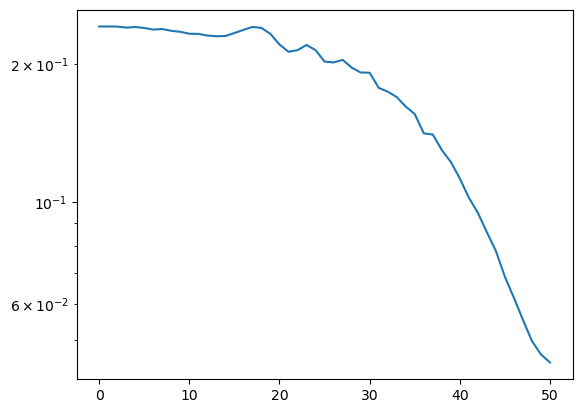

In [34]:
import matplotlib.pyplot as plt 
plt.plot(loss)
plt.yscale('log')